In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import requests
import shutil
import pandas as pd
from collections import OrderedDict
from operator import itemgetter
import geopandas as gpd
import matplotlib as mpl
from shapely import wkt

In [ ]:
import rootutils
from pathlib import Path
notebook_root = Path().resolve()
home_folder = rootutils.setup_root(str(notebook_root), indicator=".project-root", pythonpath=True)
data_dir = home_folder / "data/CropClimateX"

## Content
- download yield, production, planted/harvest area from USDA quickstats
- visualize time series of yield record per crop
- visualize spatial map of yield record frequency per crop
- create master dataframe of yield and management information 
- county selection analysis

## Target crop
- crops: corn, winter wheat, soybean, cotton, oats
- for cotton, yield records focus on upland cotton
- corn, soybean and winter wheat yield are in bushels/acre
- cotton yield is provided in lb/acre 

In [3]:
all_crops = ['CORN', 'COTTON', 'OATS', 'SOYBEANS', 'WINTER_WHEAT']
print('total number of crops', len(all_crops))

total number of crops 5


## Download yield data per crop

In [1]:
def download_usda_yield(commodity, start_year, output_dir, api_key=None):
    
    """
    download usda crop yield reference data. limit is 50000 records per csv
    params reference: https://quickstats.nass.usda.gov/api/
    
    params
        commodity: list of crop names. 
        start_year: lower bound of year requested. 
                    script uses >= start_year
        output_dir: folder to store csvs
        api_key: api key for data access.
                 request here https://quickstats.nass.usda.gov/api/

    returns 
        usa wide csv per commodity for all years
    
    
    """
    # --query params
    source_desc = 'source_desc=SURVEY'
    sector_desc = 'sector_desc=CROPS'
    agg_level_desc = 'agg_level_desc=COUNTY'
    reference_period_desc = 'reference_period_desc=YEAR' 
    data_format = 'format=CSV'
    year_start = 'year__GE={}'.format(start_year)

    constructor = '&'.join([source_desc,sector_desc, agg_level_desc,
                             reference_period_desc, year_start,
                             data_format])
    
    query_extra = {
    'CORN': ["CORN, GRAIN - YIELD, MEASURED IN BU / ACRE", 
             'CORN, GRAIN - PRODUCTION, MEASURED IN BU', 
             'CORN - ACRES PLANTED',
             'CORN, GRAIN - ACRES HARVESTED'],

    'COTTON': ["COTTON, UPLAND - YIELD, MEASURED IN LB / ACRE",
               "COTTON, UPLAND - PRODUCTION, MEASURED IN 480 LB BALES",
               "COTTON, UPLAND - ACRES PLANTED",
               "COTTON, UPLAND - ACRES HARVESTED"],

    'OATS': ["OATS - YIELD, MEASURED IN BU / ACRE",
             "OATS - PRODUCTION, MEASURED IN BU",
             "OATS - ACRES PLANTED",
             "OATS - ACRES HARVESTED"],

    'SOYBEANS': ["SOYBEANS - YIELD, MEASURED IN BU / ACRE",
                 "SOYBEANS - PRODUCTION, MEASURED IN BU",
                 "SOYBEANS - ACRES PLANTED",
                 "SOYBEANS - ACRES HARVESTED"], 
      
    'WINTER_WHEAT': ["WHEAT, WINTER - YIELD, MEASURED IN BU / ACRE", 
                     "WHEAT, WINTER - PRODUCTION, MEASURED IN BU",
                     "WHEAT, WINTER - ACRES PLANTED",
                     "WHEAT, WINTER - ACRES HARVESTED"],
    }
    
    label = ['yield', 'production', 'planted_area', 'harvested_area']

    # --fetch csv: one per commodity
    for c in commodity:

        for i, l in enumerate(label):
        
            os.makedirs(os.path.join(output_dir, l, c), exist_ok=True)
            
            # additional construction - short descritip
            if c in query_extra.keys(): 
                
                if 'WHEAT' in c:
                    url = 'https://quickstats.nass.usda.gov/api/api_GET/?key={}&{}&commodity_desc={}&short_desc={}'.format(
                        api_key, constructor, 'WHEAT', query_extra[c][i])
                    
                else:
                    url = 'https://quickstats.nass.usda.gov/api/api_GET/?key={}&{}&commodity_desc={}&short_desc={}'.format(
                        api_key, constructor, c, query_extra[c][i])         
            
            else:
                url = 'https://quickstats.nass.usda.gov/api/api_GET/?key={}&{}&commodity_desc={}'.format(
                    api_key,constructor,c)
            
            # =================================================
            local_filename='{}_usa_year_gte{}.csv'.format(c,start_year)
            with requests.get(url, stream=True) as r:
                with open(os.path.join(output_dir, l, c, local_filename), 'wb') as f: 
                    shutil.copyfileobj(r.raw, f)

        print(c, ' processing complete')       
    

### execute
- only 50000 records can be requested at a time
- the records are returned for all counties in the USA
- an API key is required to request the records
- an API key can be obtained here https://quickstats.nass.usda.gov/api

In [27]:
api_key = 'your_api_key'
download_usda_yield(all_crops, 2018, os.path.join(home_folder, 'data/yield/raw_csv_latest'), api_key)

## Create yield frequency maps from defined start year

In [16]:
def create_frequency_maps(all_crops, yield_path, preferred_year_start, preferred_year_end, 
                          county_geom, crs='epsg:4269', save_freq=False, out_dir=None):
    
    def create_id(row):
        """
        create 5-character code from state and county id
        """
        state = int(row['state_ansi'])
        county = int(row['county_ansi'])
        geoid = str(state).zfill(2) + str(county).zfill(3)
        return geoid
    
     # pre-defined bounds for frquency values
    cmap = mpl.cm.coolwarm  #viridis
    bounds=[0, 3, 6, 9, 12, 15, 18]
    # norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    
    c_geom = pd.read_csv(county_geom, dtype=str)
    
    f, axes = plt.subplots(figsize=(15, 6), ncols=3, nrows=2, gridspec_kw = {'wspace':0.1, 'hspace':0.2}, sharey=True, sharex=True)
    axs = axes.flatten()
    
    for i, c in enumerate(all_crops):
        
        try:
            # read yield and geom table
            ts =  pd.read_csv(os.path.join(yield_path, '{}/{}_usa_year_gte{}.csv'.format(c,c, preferred_year_start)),  dtype=str,  thousands=',')
            ts['year'] = ts['year'].astype(int)

            # filter by start and end year
            ts = ts[(ts['year'] >=preferred_year_start)&(ts['year'] <=preferred_year_end)]
            
            # keep relevant columns in yield table, drop nans
            ts = ts[["unit_desc", "year" ,"state_ansi" ,"county_ansi", "Value" ]].dropna()
            ts['GEOID'] = ts.apply(lambda row: create_id(row), axis=1)

            # get new df as count of geoid (ie. frequency)
            ts = ts['GEOID'].value_counts().reset_index()
            ts.columns = ['GEOID', 'Count']

            # merge to geom column
            ts_geom  = c_geom.merge(ts, on='GEOID', how='left')
            ts_geom['geometry'] = ts_geom['WKT'].apply(wkt.loads)

            # create map
            ts_gdf = gpd.GeoDataFrame(ts_geom, crs=crs)

            # activate to use class-break colorramps.
            # ts_gdf.plot(ax=axs[i], column="Count", cmap=cmap, norm = norm, legend=True, missing_kwds={
            #         "color": "lightgrey", "label": "Missing values"
            #     })
            ts_gdf.plot(ax=axs[i], column="Count",  cmap='viridis', legend=True, missing_kwds={
                    "color": "lightgrey", "label": "Missing values"})
            
            ts_gdf[c+'_Count'] = ts_gdf['Count']

            axs[i].axis('off')
            axs[i].set_title(c)
            
            if save_freq:
                os.makedirs(out_dir, exist_ok=True)
                ts_gdf.to_file(os.path.join(out_dir, '{}_frequency.geojson'.format(c)), driver='GeoJSON')
                
        except Exception as e:
            print(str(e))
            continue
        
    plt.show()
    

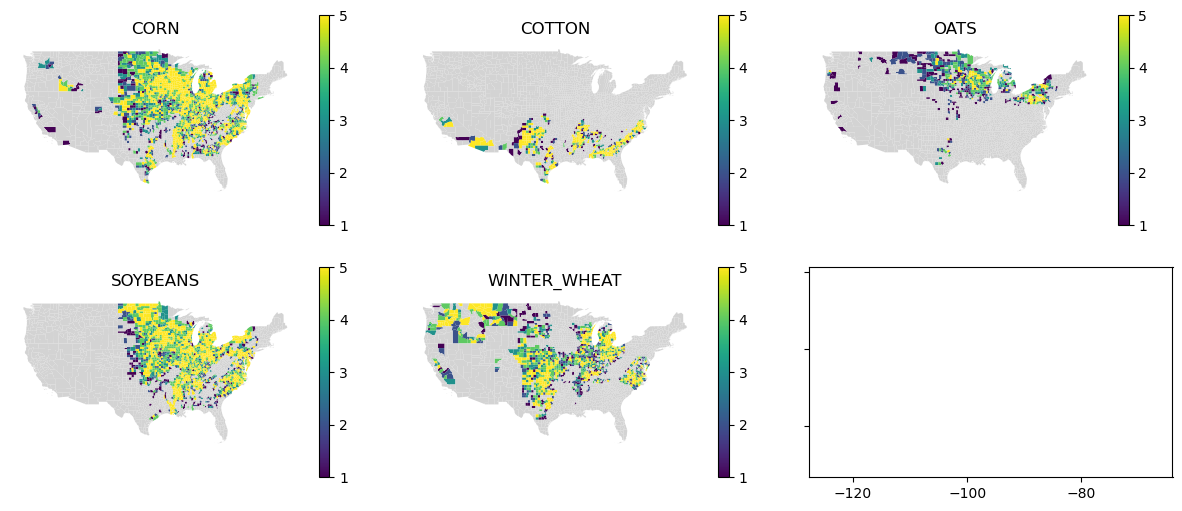

In [17]:
preferred_year_start = 2018
preferred_year_end = 2022
yield_path =  os.path.join(home_folder, 'data/yield/raw_csv_latest/yield')
geom_path = os.path.join(home_folder, 'data/geometry/cb_2021_us_county_500k.csv')

# plot frequency maps. to save maps, add argument save_freq=True
create_frequency_maps(sorted(all_crops), yield_path, preferred_year_start, 
                      preferred_year_end, geom_path)

## Create master yield dataframe for selected crops

In [26]:
def prepare_master_df(csv_path, list_crops, start_year=2018, end_year=2022, 
                      target_col='Value', rename_target_col=None):
    
    list_of_df = []
    
    for crop in list_crops:
        
        df = pd.read_csv('{}/{}/{}_usa_year_gte{}.csv'.format(csv_path, crop, crop, start_year))
        df = df[[ 'state_fips_code', 'county_code', 'county_name', 'year', target_col]]
        
        # remove unnamed counties
        df = df[df['county_name'] != 'OTHER (COMBINED) COUNTIES']
        
        # filter by year
        df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

        # assign cropname
        df['crop'] = crop.lower()
        df[rename_target_col] = df[target_col]

        # remove thousands separator
        df[rename_target_col] = pd.to_numeric(df[rename_target_col].astype(str).str.replace(',', ''))
        
        # unit conversion for yield and production
        if rename_target_col == 'yield' or 'production' in rename_target_col:

            # bu to lb for all except cotton. NB: cotton is in lb
            if crop == 'CORN':
                df[rename_target_col] = df[rename_target_col] * 56
            elif crop == 'WINTER_WHEAT':
                df[rename_target_col] = df[rename_target_col] * 60
            elif crop == 'OATS':
                df[rename_target_col] = df[rename_target_col] * 32
            elif crop == 'SOYBEANS':
                df[rename_target_col] = df[rename_target_col] * 60

        # unit conversion for area. acre to hectare
        elif 'harvested' in rename_target_col or 'planted' in rename_target_col:
            df[rename_target_col] = df[rename_target_col] / 2.471   

        # convert yield to t/ha
        if rename_target_col == 'yield': 
            df[rename_target_col] = df[rename_target_col] / 892.2

        if 'production' in rename_target_col:
            # convert bale weight to lb
            if crop =='COTTON': 
                df[rename_target_col] = df[rename_target_col] * 480
            
            # convert to tonnes
            df[rename_target_col] = df[rename_target_col] * 0.00045359237

        # zfill county and state
        df['state_fips_code'] = df['state_fips_code'].astype(str).str.zfill(2)
        df['county_code'] = df['county_code'].astype(str).str.zfill(3)
        df['geoid'] = df['state_fips_code'] + df['county_code']
        
        # drop columns
        df.drop(['county_name', 'state_fips_code', \
                 'county_code', target_col], axis=1, inplace=True)
        
        list_of_df.append(df)
    
    # concat dataframe to create master df
    master_df = pd.concat(list_of_df, ignore_index=True)

    # set index
    # master_df.set_index('geoid', inplace=True)

    # remove records with 0 values
    # master_df = master_df[master_df['yield'] > 0]
    
    return master_df

In [30]:
all_crops = ['CORN', 'COTTON', 'OATS', 'SOYBEANS', 'WINTER_WHEAT']
csv_path = os.path.join(home_folder, 'data/yield/raw_csv_latest')
start_year = 2018
end_year = 2022

yield_df = prepare_master_df(os.path.join(csv_path, 'yield'), all_crops, 
                             start_year, end_year,'Value', 'yield')

production_df = prepare_master_df(os.path.join(csv_path, 'production'), 
                                  all_crops, start_year, end_year,'Value', 'production')

harvested_df = prepare_master_df(os.path.join(csv_path, 'harvested_area'), 
                                 all_crops, start_year, end_year,'Value', 'harvested_area')

planted_df = prepare_master_df(os.path.join(csv_path, 'planted_area'), 
                               all_crops, start_year, end_year,'Value', 'planted_area')



# merge variables
master_df = yield_df.merge(production_df, on=['geoid', 'crop', 'year'], how='left') \
               .merge(harvested_df, on=['geoid', 'crop', 'year'], how='left') \
               .merge(planted_df, on=['geoid', 'crop', 'year'], how='left')



# filter with final counties
final_selection =  gpd.read_file(os.path.join(data_dir, 'county_list.geojson'))
master_df = master_df[master_df['geoid'].isin(final_selection['GEOID'])]

## save master df

In [32]:
output_dir = os.path.join(data_dir, 'yield/yield_master_df')
master_df.to_csv(os.path.join(output_dir, 'master_yield_df.csv'), decimal='.', index=False)
master_df.head(10)

,year,crop,yield,geoid,production,harvested_area,planted_area
0,2022,corn,5.900022,01033,40819.684561,6920.275192,7163.091866
1,2021,corn,10.965254,01033,91418.820619,8336.705787,8458.114124
2,2020,corn,11.002914,01033,96168.839918,8741.400243,8943.747471
3,2019,corn,10.105358,01033,87126.022430,8619.991906,8781.869688
4,2018,corn,9.640888,01033,64366.571672,6677.458519,6758.397410
6,2022,corn,5.209594,01077,49760.897358,9550.789154,9834.075273
7,2021,corn,11.059404,01077,114584.690140,10360.178066,10602.994739
8,2020,corn,10.394082,01077,110215.688432,10602.994739,10845.811412
9,2019,corn,10.814616,01077,100690.248662,9307.972481,9510.319709
10,2018,corn,10.375252,01077,78083.204941,7527.316876,7689.194658


In [34]:
# cross-validate: yield = production/harvested_area
master_df['val'] = master_df['production']/master_df['harvested_area']
master_df

,year,crop,yield,geoid,production,harvested_area,planted_area,val
0,2022,corn,5.900022,01033,40819.684561,6920.275192,7163.091866,5.898564
1,2021,corn,10.965254,01033,91418.820619,8336.705787,8458.114124,10.965821
2,2020,corn,11.002914,01033,96168.839918,8741.400243,8943.747471,11.001537
3,2019,corn,10.105358,01033,87126.022430,8619.991906,8781.869688,10.107437
4,2018,corn,9.640888,01033,64366.571672,6677.458519,6758.397410,9.639382
...,...,...,...,...,...,...,...,...
21322,2019,winter_wheat,4.492266,55131,6885.532177,1533.791987,1740.186159,4.489222
21323,2018,winter_wheat,4.606590,55131,8355.171455,1813.031161,1861.594496,4.608399
21324,2022,winter_wheat,5.554808,55133,5551.970609,999.595306,1173.613921,5.554218
21325,2021,winter_wheat,4.324143,55133,5334.246271,1234.318090,1416.430595,4.321614
